In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
def load_env_to_dict(file_path):
    env_dict = {}
    with open(file_path, "r") as file:
        for line in file:
            # Remove whitespace and ignore comments or empty lines
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            # Split the line into key and value
            key, value = line.split("=", 1)
            env_dict[key.strip()] = value.strip()
    return env_dict

In [3]:
file_path = "/mnt/Exdisk/git-cuongpiger/secret/work/vngcloud/ai-platform/env"
env_variables = load_env_to_dict(file_path)

In [4]:
import os

from langchain_google_vertexai import ChatVertexAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, BaseMessage
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import chain
from langgraph.prebuilt import create_react_agent
from langchain_core.utils.function_calling import tool_example_to_messages
from pydantic import BaseModel, Field
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_google_vertexai import create_structured_runnable
from enum import Enum
from langgraph.graph.message import add_messages
from langchain_core.messages import trim_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain import hub
from langchain_ollama import ChatOllama


from IPython.display import display, Markdown, Latex

from typing_extensions import Annotated, TypedDict
from typing import List, Optional, Sequence

from IPython.display import Image, display

/mnt/Exdisk/git-cuongpiger/langchain-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from langchain_community.utilities import SQLDatabase

In [6]:
db = SQLDatabase.from_uri(
    "sqlite:////mnt/Exdisk/git-cuongpiger/langchain-labs/data/Chinook.db"
)
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [7]:
class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [8]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = (
    "/mnt/Exdisk/git-cuongpiger/secret/work/vngcloud/ai-platform/vertex-ai-credential.json"
)

In [9]:
# llm = ChatVertexAI(temperature=0, model="gemini-1.5-flash")
llm = ChatOllama(
    temperature=0,
    num_ctx=4096,
    model="llama3.3:70b",
    base_url=env_variables["OLLAMA_SERVER_URL"],
)

In [10]:
query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

/mnt/Exdisk/git-cuongpiger/langchain-labs/.venv/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


In [11]:
class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 3,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )

    print(f"prompt: {prompt}")
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    print(f"Result is: {result}")
    return {"query": result["query"]}

In [15]:
write_query({"question": "How many Employe?"})

prompt: messages=[SystemMessage(content='Given an input question, create a syntactically correct sqlite query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most 3 results. You can order the results by a relevant column to return the most interesting examples in the database.\n\nNever query for all the columns from a specific table, only ask for a the few relevant columns given the question.\n\nPay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.\n\nOnly use the following tables:\n\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTi

TypeError: 'NoneType' object is not subscriptable

In [13]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

In [14]:
def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [15]:
execute_query({"query": "SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;"})

{'result': '[(8,)]'}

In [16]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [17]:
from langgraph.graph import START, StateGraph

In [18]:
graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

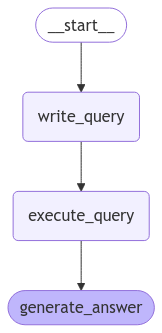

In [19]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

Result is: None


TypeError: 'NoneType' object is not subscriptable

In [12]:
llm.invoke("Kubernetes là gì?")

AIMessage(content='Kubernetes (còn được gọi là K8s) là một hệ thống mã nguồn mở để tự động hóa việc triển khai, quản lý và mở rộng các ứng dụng được chứa trong các container. Nó cung cấp một framework để chạy các ứng dụng phân tán, giúp đơn giản hóa quá trình quản lý và vận hành các môi trường phức tạp.\n\nKubernetes được thiết kế bởi Google và hiện được duy trì bởi Cloud Native Computing Foundation (CNCF). Nó hỗ trợ nhiều loại container runtime, bao gồm Docker, rkt và cri-o.\n\nMột số tính năng chính của Kubernetes bao gồm:\n\n1. **Triển khai ứng dụng**: Kubernetes cho phép bạn triển khai các ứng dụng một cách dễ dàng và nhanh chóng.\n2. **Quản lý trạng thái**: Kubernetes giúp quản lý trạng thái của các ứng dụng, bao gồm việc khởi động, dừng và cập nhật.\n3. **Tự động hóa**: Kubernetes cung cấp tính năng tự động hóa để quản lý các ứng dụng, bao gồm việc tự động mở rộng và thu hẹp.\n4. **Cân bằng tải**: Kubernetes giúp cân bằng tải giữa các máy chủ để đảm bảo hiệu suất cao nhất.\n5. **